### Conventional Volatility - STD

In [1]:
from scipy import stats
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
ticker='KO'
start='2001-1-1'
end='2021-1-1'
def get_price(x, start, end):
    df=yf.download(x, start=start, end=end)
    return df
stock = get_price(ticker,start,end)
stock['Adj_Close_ret'] = stock['Adj Close'].pct_change()
stock = stock.dropna()
ret = stock.Adj_Close_ret.to_numpy()
ret_std = np.std(ret)*np.sqrt(252)
print(ret_std)

[*********************100%***********************]  1 of 1 completed
0.19634913983865623


### Test of normality

In [3]:
print ('ticker=',ticker,'W-test, P-value')
print (stats.shapiro(ret))

ticker= KO W-test, P-value
(0.9038962721824646, 0.0)


C:\Users\Pau\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Fat Tails

In [4]:
print( 'Stock  n       =',len(ret))
print( 'Stock  mean    =',round(np.mean(ret),9))
print( 'Stock  std     =',round(np.std(ret),9))
print( 'Stock  skewness=',round(stats.skew(ret),9))
print( 'Stock  kurtosis=',round(stats.kurtosis(ret),9))

Stock  n       = 5031
Stock  mean    = 0.000304567
Stock  std     = 0.012368833
Stock  skewness= -0.058337696
Stock  kurtosis= 10.733619446


### LPSD (Lower Partial Standard Deviation)

$LPSD^{\\ 2} = \sum_{i=I}^m\frac{(R_i - R_f)}{n-1}\\ R_i-R_f<0$

In [5]:
import datetime as datetime

with open('F-F_Research_Data_Factors_daily.txt','r') as file:
    data = file.readlines()
    f=[]
    index=[]
    for i in range(1,len(data)):
        t=data[i].split()
        t0_n=int(t[0])
        y=int(t0_n/10000)
        m=int(t0_n/100)-y*100
        d=int(t0_n)-y*10000-m*100
        index.append(datetime.datetime(y,m,d))
        for j in range(1,5):
            k=float(t[j])
            f.append(k)


In [6]:
n = len(f)
f1=np.reshape(f,[int(n/4),4])
ff=pd.DataFrame(f1,index=index,columns=['Mkt_Rf','SMB','HML','Rf'])
ff.to_pickle(r'C:\Users\Pau\temp\ffDaily.picklex')

In [7]:
ff = pd.read_pickle(r'C:\Users\Pau\temp\ffDaily.picklex')
final = pd.merge(stock['Adj_Close_ret'], ff, left_index=True, right_index=True)
k = final['Adj_Close_ret'] - final['Rf']
k2=k[k<0]
LPSD=np.sqrt(sum((k2**2)/(k2.shape[0]-1)))*np.sqrt(252)
print(' LPSD (annualized) for ', ticker, 'is ',round(LPSD,3))

 LPSD (annualized) for  KO is  0.252


### Equivalency of Volatility over two different periods

In [8]:
ticker = 'SPY'
start_period1 = '2008-1-1'
end_period1 = '2014-1-1'
start_period2 = '2001-1-1'
end_period2 = '2007-12-31'
spy_1 = get_price(ticker,start_period1,end_period1)
spy_1['Adj_Close_ret'] = spy_1['Adj Close'].pct_change()
spy_1 = spy_1.dropna()
ret_1 = spy_1.Adj_Close_ret.to_numpy()
ret_std_1 = np.std(ret_1)*np.sqrt(252)

spy_2 = get_price(ticker,start_period2,end_period2)
spy_2['Adj_Close_ret'] = spy_2['Adj Close'].pct_change()
spy_2 = spy_2.dropna()
ret_2 = spy_2.Adj_Close_ret.to_numpy()
ret_std_2 = np.std(ret_2)*np.sqrt(252)
print(ret_std_1, ret_std_2)
print('T value ,    p-value ')
print(stats.bartlett(ret_1, ret_2)) #Bartlett's test tests the null hypothesis that all input samples
                                   #are from populations with equal variances.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.2435021197893464 0.17064027359636422
T value ,    p-value 
BartlettResult(statistic=204.52468226459277, pvalue=2.150298021811155e-46)


In [9]:
import statsmodels.api as sm
import scipy as sp
def breusch_pagan_test(y,x):
    results=sm.OLS(y,x).fit()
    resid=results.resid
    n=len(resid)
    sigma2 = sum(resid**2)/n
    f = resid**2/sigma2 - 1
    results2=sm.OLS(f,x).fit()
    fv=results2.fittedvalues
    bp=0.5 * sum(fv**2)
    df=results2.df_model
    p_value=1-sp.stats.chi.cdf(bp,df)
    return round(bp,6), df, round(p_value,7)

sp.random.seed(12345)
n=100
x=[]
error1=sp.random.normal(0,1,n)
error2=sp.random.normal(0,2,n)
for i in range(n):
    if i%2==1:
        x.append(1)
    else:
        x.append(-1)
        
y1=x+np.array(x)+error1
y2=np.zeros(n)

for i in range(n):
    if i%2==1:
        y2[i]=x[i]+error1[i]
    else:
        y2[i]=x[i]+error2[i]
print ('y1 vs. x (we expect to accept the null hypothesis)')
bp=breusch_pagan_test(y1,x)

print('BP value,    df,    p-value')
print ('bp =', bp)
bp=breusch_pagan_test(y2,x)
print ('y2 vs. x    (we expect to rject the null hypothesis)')
print('BP value,    df,    p-value')
print('bp =', bp)

y1 vs. x (we expect to accept the null hypothesis)
BP value,    df,    p-value
bp = (0.596446, 1.0, 0.5508776)
y2 vs. x    (we expect to rject the null hypothesis)
BP value,    df,    p-value
bp = (17.611054, 1.0, 0.0)


### Volatilty smile and skewness

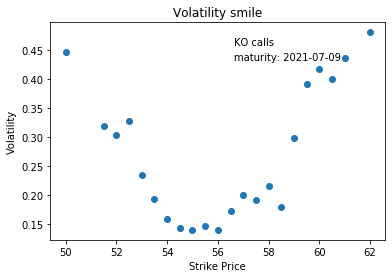

In [10]:
import matplotlib.pyplot as plt

stock = yf.Ticker('KO')
options = stock.option_chain('2021-07-09')
x = options[0]['strike']
y = options[0]['impliedVolatility']
plt.title("Volatility smile")
plt.figtext(0.55,0.80,"KO calls")
plt.figtext(0.55,0.75,"maturity: 2021-07-09")
plt.ylabel("Volatility")
plt.xlabel("Strike Price")
plt.plot(x,y,'o')
plt.show()

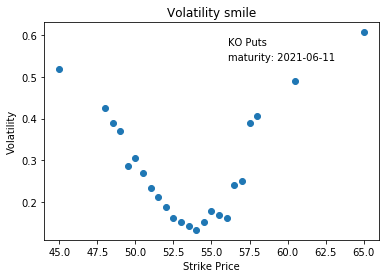

In [11]:
x = options[1]['strike']
y = options[1]['impliedVolatility']
plt.title("Volatility smile")
plt.figtext(0.55,0.80,"KO Puts")
plt.figtext(0.55,0.75,"maturity: 2021-06-11")
plt.ylabel("Volatility")
plt.xlabel("Strike Price")
plt.plot(x,y,'o')
plt.show()